In [1]:
import glob
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import keras
import random
import matplotlib.pyplot as plt
import datetime
from typing import Union, List, Tuple
import os
import time
from keras.models import Model
from keras.layers import (BatchNormalization, Flatten, Input, Reshape, Dense, MaxPool2D,
                          Conv1D, Concatenate, Activation)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp

2023-02-07 20:44:33.307500: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-07 20:44:33.635381: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-07 20:44:33.652677: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-07 20:44:33.652736: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
train_df = pd.read_csv('train_1Dx.csv',nrows=100000)
test_df = pd.read_csv('test_1Dx.csv',nrows=5000)

In [3]:
def inverse_cot(cota):
    pi = 3.14159265359
    return np.array([math.fmod(math.atan(1/x)+pi,pi)/pi for x in cota])

In [4]:
X_train = train_df.drop(columns=['x-midplane','cotAlpha']).values
X_test = test_df.drop(columns=['x-midplane','cotAlpha']).values

y_train = inverse_cot(train_df['cotAlpha'].values)
y_test = inverse_cot(test_df['cotAlpha'].values)

In [5]:
# scale so that it is between 0 and 1
def scale(X):
    width = np.max(X) - np.min(X)
    return ( X-np.min(X) ) / width

In [6]:
X_train = scale(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scale(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

(array([1042.,  499.,  378.,  317.,  313.,  282.,  328.,  385.,  503.,
         953.]),
 array([0.03967564, 0.13173516, 0.22379468, 0.3158542 , 0.40791373,
        0.49997325, 0.59203277, 0.68409229, 0.77615181, 0.86821134,
        0.96027086]),
 <BarContainer object of 10 artists>)

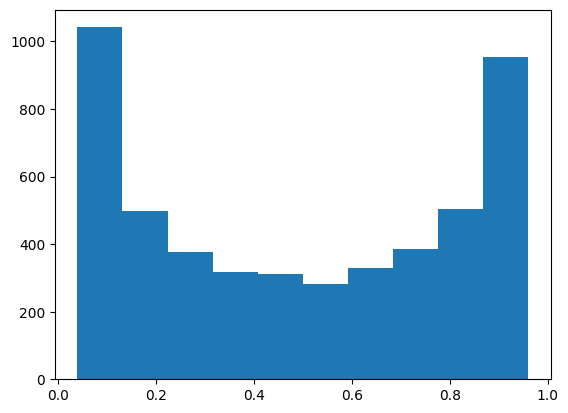

In [7]:
plt.hist(y_test)

2023-02-07 20:45:06.017309: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-07 20:45:06.017404: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-07 20:45:06.017455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-jennetd): /proc/driver/nvidia/version does not exist
2023-02-07 20:45:06.018742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


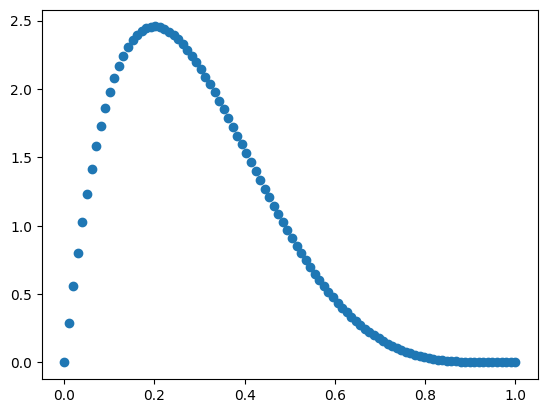

In [8]:
dist = tfp.distributions.Beta(concentration1 = 2,
                              concentration0 = 5)
    
xpoints = np.linspace(0,1,100)
plt.scatter(xpoints,dist.prob(xpoints)) 

In [9]:
#def log_beta(x, alpha, beta):
    # x in (0, 1), alpha > 0, beta > 0
#    return (alpha - 1.)*tf.math.log(x) + (beta - 1.)*tf.math.log(1 - x) \
#            - tf.math.lgamma(alpha) - tf.math.lgamma(beta) + tf.math.lgamma(alpha + beta)

def beta_loss(y, p):
    
    #tf.print('y',y)
    
    maxval = 1e9
    minval = 1e-9
    pi = 3.14159265359
    
    alpha = tf.math.softplus(tf.gather(params=p, indices=[0], axis=1))
    beta = tf.math.softplus(tf.gather(params=p, indices=[1], axis=1))
    
    dist = tfp.distributions.Beta(concentration1 = alpha,
                                  concentration0 = beta)
    
    likelihood = dist.prob(y)   

    NLL = -1*tf.math.log(likelihood)
    #tf.print('NLL',NLL)
    return tf.keras.backend.sum(NLL,axis=1)    

In [10]:
def CreateModel(shape):
    x = x_in = Input(shape)
    x = Dense(64, name="dense1")(x)
    #x = BatchNormalization()(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(2, name="dense2")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

model=CreateModel(X_train.shape[1:])

model.compile(optimizer=Adam(),
              loss=beta_loss)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense1 (Dense)              (None, 64)                1408      
                                                                 
 relu1 (Activation)          (None, 64)                0         
                                                                 
 dense2 (Dense)              (None, 2)                 130       
                                                                 
Total params: 1,538
Trainable params: 1,538
Non-trainable params: 0
_________________________________________________________________


In [11]:
es = EarlyStopping(patience=20,
                  restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=80, 
                    batch_size=64,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/80
1250/1250 [==============================] - 6s 4ms/step - loss: -0.1439 - val_loss: -0.1979
Epoch 2/80
1250/1250 [==============================] - 4s 3ms/step - loss: -0.2184 - val_loss: -0.2312
Epoch 3/80
1250/1250 [==============================] - 4s 3ms/step - loss: -0.2434 - val_loss: -0.2500
Epoch 4/80
1250/1250 [==============================] - 4s 3ms/step - loss: -0.2596 - val_loss: -0.2637
Epoch 5/80
1250/1250 [==============================] - 5s 4ms/step - loss: -0.2718 - val_loss: -0.2735
Epoch 6/80
1250/1250 [==============================] - 4s 4ms/step - loss: -0.2809 - val_loss: -0.2811
Epoch 7/80
1250/1250 [==============================] - 4s 3ms/step - loss: -0.2875 - val_loss: -0.2865
Epoch 8/80
1250/1250 [==============================] - 4s 3ms/step - loss: -0.2927 - val_loss: -0.2909
Epoch 9/80
1250/1250 [==============================] - 4s 3ms/step - loss: -0.2967 - val_loss: -0.2943
Epoch 10/80
1250/1250 [==============================] - 4s 3ms/

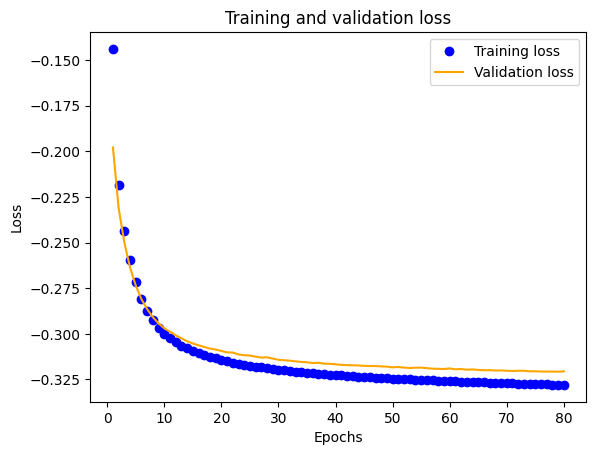

In [22]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.yscale('Log')
plt.legend()
plt.show()

In [13]:
pi = 3.14159265359

In [23]:
p_test = model.predict(X_test)
df = pd.DataFrame(p_test,columns=['alpha','beta'])
df['Atrue'] = y_test*pi
df['cotAtrue'] = np.array([math.tan(a) for a in df['Atrue']])
df['mean'] = df['alpha']/(df['alpha']+df['beta'])*pi
df['mode'] = (df['alpha']-1)/(df['alpha']+df['beta']-2)*pi
df['sigma'] = df['alpha']*df['beta']/((df['alpha']+df['beta'])*(df['alpha']+df['beta'])*(df['alpha']+df['beta']+1))*pi

#df.to_csv("test_1DcotAGauss.csv",header=False,index=False)

157/157 [==============================] - 0s 2ms/step


In [24]:
residuals = df['Atrue'] - df['mode']
print(np.mean(residuals),np.std(residuals))

-0.06514492623859641 2.2008077920968794


/tmp/ipykernel_20076/2096865527.py:2: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


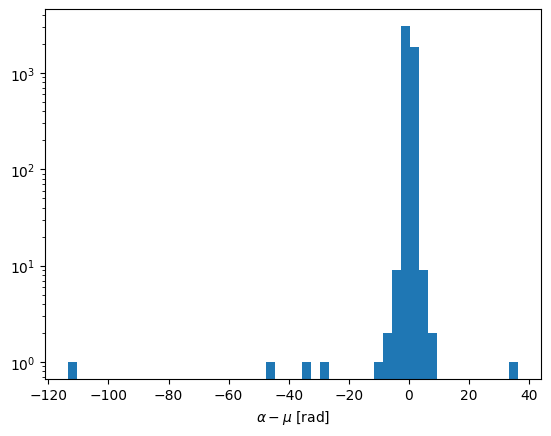

/tmp/ipykernel_20076/2096865527.py:7: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


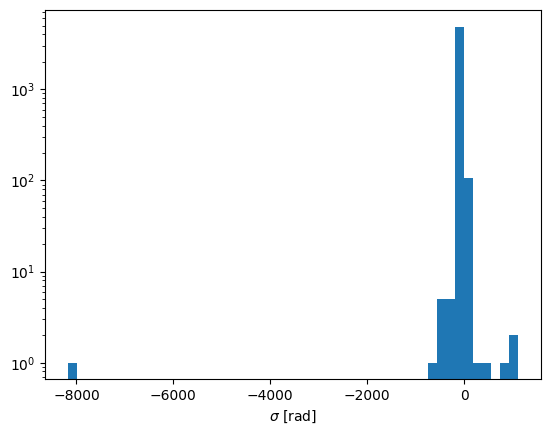

In [25]:
plt.hist(residuals,bins=50)
plt.yscale('Log')
plt.xlabel(r'$\alpha-\mu$ [rad]')
plt.show()

plt.hist(df['sigma'],bins=50);
plt.yscale('Log')
plt.xlabel(r'$\sigma$ [rad]')
plt.show()

plt.hist(tf.math.softplus(df['alpha']),bins=50)
plt.yscale('Log')
plt.xlabel(r'$\alpha$ [rad]')
plt.show()

plt.hist(df['sigma'],bins=50);
plt.yscale('Log')
plt.xlabel(r'$\sigma$ [rad]')
plt.show()

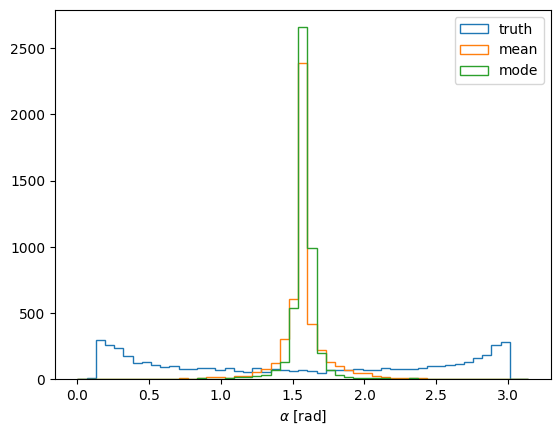

In [30]:
plt.hist(df['Atrue'],bins=np.linspace(0,pi,50),histtype='step',label='truth')
plt.hist(df['mean'],bins=np.linspace(0,pi,50),histtype='step',label='mean')
plt.hist(df['mode'],bins=np.linspace(0,pi,50),histtype='step',label='mode')
#plt.yscale('Log')
plt.xlabel(r'$\alpha$ [rad]')
plt.legend()
plt.show()

(-10.0, 25.0)

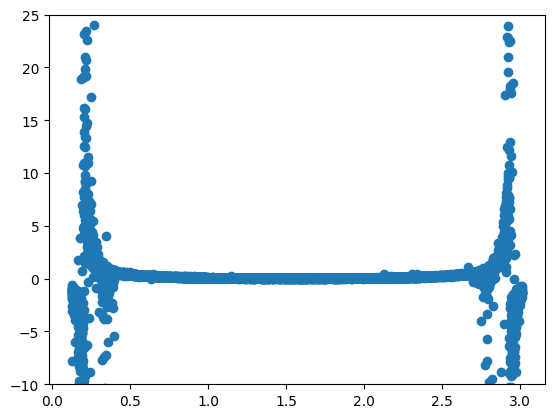

In [18]:
plt.scatter(df['Atrue'],df['sigma'])
plt.ylim(-10,25)

In [19]:
pulls = residuals/df['sigma']

Text(0.5, 0, 'pull')

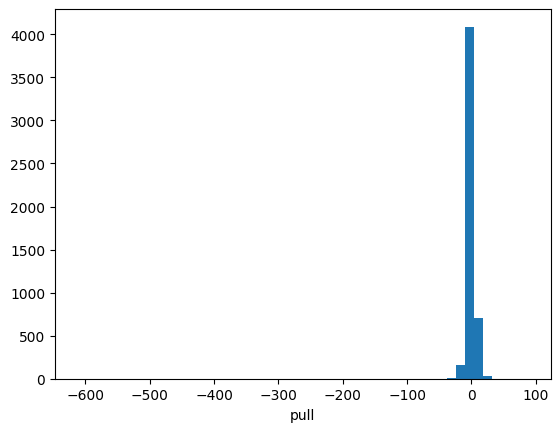

In [20]:
plt.hist(pulls,bins=50);
plt.xlabel('pull')

In [21]:
print(np.mean(pulls),np.std(pulls))

-0.22241831342974439 10.812397322305545
